<a href="https://colab.research.google.com/github/ak2449/SNN-Project/blob/main/SNN_Multi_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multi Class Classification

In [ ]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 3.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import functional as SF
import matplotlib.pyplot as plt
from snntorch import surrogate
import math, time
import torch, torch.nn as nn, torch.nn.functional as F

In [ ]:
# --- 1. Data Generation Parameters ---
c = 3e8
fc = 77e9
bw = 150e6
T_chirp = 10e-6
k = bw / T_chirp
fs = 2 * bw
t = np.arange(0, T_chirp, 1/fs)
n_samples = len(t)
tx_phase = 2 * np.pi * (fc * t + (k/2) * t**2)
Tx = np.exp(1j * tx_phase)

MIN_RANGE_METERS = 25.0
CLASS_WIDTH_METERS = 50.0
CLASS_GAP_METERS = 25.0

# --- Data simulation function (MODIFIED FOR MULTI-CLASS) ---
def generate_sample(batch_size, num_classes=3):
    """
    Generates a batch of beat signals and corresponding labels for multi-class.
    """
    # Create empty tensors to store the data
    # Shape: (batch_size, num_timesteps, 2) for I/Q channels
    data_tensor = torch.zeros((batch_size, n_samples, 2))
    # Shape: (batch_size)
    label_tensor = torch.zeros((batch_size), dtype=torch.long)

    # --- MODIFIED: Automatically generate ranges ---
    ranges = []
    current_start = MIN_RANGE_METERS
    for _ in range(num_classes):
        current_end = current_start + CLASS_WIDTH_METERS
        ranges.append((current_start, current_end))
        # Set the start for the next class
        current_start = current_end + CLASS_GAP_METERS
    # --- END MODIFIED ---

    for i in range(batch_size):
        # Create a random target
        # Pick one of the classes uniformly
        label = np.random.randint(0, num_classes)
        class_range = ranges[label]
        target_range = np.random.uniform(class_range[0], class_range[1])

        # --- Simulate the beat signal ---
        tau = (2 * target_range) / c
        t_rx = t - tau
        rx_phase = 2 * np.pi * (fc * t_rx + (k/2) * t_rx**2)
        Rx = np.exp(1j * rx_phase)
        Mix_signal = Tx * np.conj(Rx) # Simplified (no noise/atten)

        # Use the real part as the input signal (this comment is from original, but the code stacks I/Q)
        iq_signal = np.stack([np.real(Mix_signal), np.imag(Mix_signal)], axis=-1)

        # Store in tensors
        data_tensor[i] = torch.tensor(iq_signal, dtype=torch.float)
        label_tensor[i] = torch.tensor(label, dtype=torch.long)


    return data_tensor, label_tensor

In [ ]:
def preprocess_batch(x, decim=20, add_awgn=True, snr_db_range=(10, 25)):
    """
    x: [B, T, 2] float (Real and Imaginary parts as channels)
    returns: [B, T', 2]
    """
    B, T, C = x.shape
    # [B, C, T] for 1D ops on each channel
    x = x.permute(0, 2, 1)

    # simple average-pool decimation
    x = F.avg_pool1d(x, kernel_size=decim, stride=decim)  # [B,C,T']

    # per-sample normalization over time, for each channel
    mean = x.mean(dim=2, keepdim=True)
    std = x.std(dim=2, keepdim=True).clamp_min(1e-6)
    x = (x - mean) / std

    # optional light AWGN augmentation (train mode can toggle this)
    if add_awgn:
        B, C, Tp = x.shape
        # choose an SNR per sample
        snr_db = torch.empty(B, 1, 1, device=x.device).uniform_(*snr_db_range)
        snr = 10 ** (snr_db / 10)
        sig_pow = (x**2).mean(dim=2, keepdim=True).clamp_min(1e-6)
        noise_pow = sig_pow / snr
        noise = torch.randn_like(x) * noise_pow.sqrt()
        x = x + noise

    # back to [B, T', C]
    x = x.permute(0, 2, 1)
    return x

Device: cpu
Training for 4 classes...
Epoch 01 | loss=1.3877 | mean_spike=0.001
Epoch 02 | loss=1.3863 | mean_spike=0.028
Epoch 03 | loss=1.3794 | mean_spike=0.072
Epoch 04 | loss=1.3681 | mean_spike=0.095
Epoch 05 | loss=1.3623 | mean_spike=0.088
Epoch 06 | loss=1.3581 | mean_spike=0.164
Epoch 07 | loss=1.2627 | mean_spike=0.289
Epoch 08 | loss=1.2163 | mean_spike=0.263
Epoch 09 | loss=1.1853 | mean_spike=0.266
Epoch 10 | loss=1.1835 | mean_spike=0.244
Epoch 11 | loss=1.1826 | mean_spike=0.272
Epoch 12 | loss=1.1679 | mean_spike=0.279
Epoch 13 | loss=1.1605 | mean_spike=0.288
Epoch 14 | loss=1.1625 | mean_spike=0.218
Epoch 15 | loss=1.1609 | mean_spike=0.271
Epoch 16 | loss=1.1586 | mean_spike=0.227
Epoch 17 | loss=1.1581 | mean_spike=0.250
Epoch 18 | loss=1.1500 | mean_spike=0.271
Epoch 19 | loss=1.1486 | mean_spike=0.256
Epoch 20 | loss=1.1460 | mean_spike=0.263
Training complete.
Test accuracy: 49.32%

Generating loss plot...


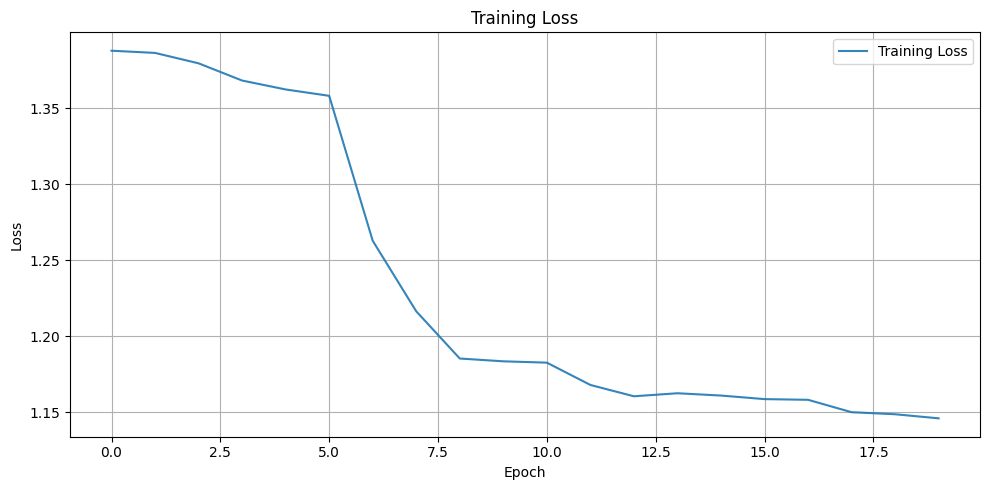

In [ ]:
#Use gpu if possible otherwise CPU is used
device = "cuda" if torch.cuda.is_available() else "cpu"

# Choose decimation to target ~150 steps from 3000
D = 5
NUM_CLASSES = 4 # <-- Define number of classes

# --- SNN model (time-major loop) (MODIFIED FOR MULTI-CLASS) ---
class BeatSNN(nn.Module):
    def __init__(self, in_dim=2, hidden=20, num_outputs=2, beta=0.95, threshold=0.75):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.lif1 = snn.Leaky(beta=beta, threshold=threshold,spike_grad=surrogate.fast_sigmoid())
        # *** CHANGED: Output layer now has `num_outputs` neurons ***
        self.fc2 = nn.Linear(hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, threshold=threshold,spike_grad=surrogate.fast_sigmoid())

        # Good inits
        nn.init.kaiming_normal_(self.fc1.weight); nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_normal_(self.fc2.weight); nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        """
        x: [B, T', 2] (Real and Imaginary parts as channels)
        returns spk_out: [T', B, num_outputs]
        """
        B, T, _ = x.shape
        # init states for this batch on the right device
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk_rec = []
        for t in range(T):
            h1 = self.fc1(x[:, t, :])
            s1, mem1 = self.lif1(h1, mem1)
            h2 = self.fc2(s1)
            s2, mem2 = self.lif2(h2, mem2)
            spk_rec.append(s2)
        # *** Output shape is now [T', B, num_outputs] ***
        return torch.stack(spk_rec, dim=0)

# --- Training setup ---
# *** CHANGED: Instantiate model with num_outputs=NUM_CLASSES ***
net = BeatSNN(num_outputs=NUM_CLASSES).to(device)
opt = torch.optim.Adam(net.parameters(), lr=2e-3)
# SF.ce_rate_loss() already supports multi-class classification
loss_fn = SF.ce_rate_loss()
grad_clip = 1.0

num_epochs = 20
batches_per_epoch = 64
batch_size = 64

print(f"Device: {device}")
print(f"Training for {NUM_CLASSES} classes...")

loss_hist = []
for epoch in range(1, num_epochs + 1):
    net.train()
    running = 0.0

    for _ in range(batches_per_epoch):
        # 1) synth batch from your generator
        data, targets = generate_sample(batch_size, num_classes=NUM_CLASSES)
        data = data.to(device)           # [B,T,1]
        targets = targets.to(device)
        # 2) preprocess
        data = preprocess_batch(data, decim=D, add_awgn=True)
        # 3) forward
        spk_rec = net(data)              # [T',B,NUM_CLASSES]
        # 4) loss (no change needed)
        loss = loss_fn(spk_rec, targets)
        running += loss.item()
        # 5) step
        opt.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), grad_clip)
        opt.step()

    avg = running / batches_per_epoch
    loss_hist.append(avg)

    # quick spike-rate sanity: mean spikes per time/neuron
    with torch.no_grad():
        spk_mean = spk_rec.float().mean().item()
    print(f"Epoch {epoch:02d} | loss={avg:.4f} | mean_spike={spk_mean:.3f}")

print("Training complete.")

# --- Eval (No changes needed) ---
net.eval()
with torch.no_grad():
    test_data, test_targets = generate_sample(1024, num_classes=NUM_CLASSES)
    test_data = test_data.to(device)
    test_targets = test_targets.to(device)

    test_data = preprocess_batch(test_data, decim=D, add_awgn=False)  # no noise in eval

    spk = net(test_data)                 # [T',B,NUM_CLASSES]
    rates = spk.sum(dim=0)               # [B,NUM_CLASSES]
    pred = rates.argmax(dim=1)           # [B]
    acc = (pred == test_targets).float().mean().item()

print(f"Test accuracy: {acc*100:.2f}%")

print("\nGenerating loss plot...")
fig = plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(loss_hist, label="Training Loss", alpha=0.9)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()